In [1]:
import os
import re
from dotenv import load_dotenv  
import psycopg2
import requests as rq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from scipy.stats import linregress

In [2]:
# Import API key
load_dotenv('./.env')
nasa_key = os.getenv('nasa_key');

In [3]:
dates = ['2021-01-01','2020-01-01', '2019-01-01', '2018-01-01', '2017-01-01']
responses = []

url = 'https://api.nasa.gov/neo/rest/v1/feed?'

for date in dates:
    params = {
        'start_date': date,
        'api_key': nasa_key
    }
    responses.append(rq.get(url, params=params))

In [4]:
# url = f'https://api.nasa.gov/neo/rest/v1/neo/browse/?api_key={nasa_key}'
# resp = rq.get(url)

In [5]:
# resp.json()['near_earth_objects'][0]

In [6]:
asteroid_data = [resp.json()['near_earth_objects'] for resp in responses if resp.status_code == 200]
len(asteroid_data)

5

In [7]:
asteroid_specs = {
    'id': [],
    'day': [],
    'asteroid_name': [],
    'min_diam_m': [],
    'max_diam_m': [],
    'min_diam_f': [],
    'max_diam_f': [],
    'hazard_to_earth': []
}

asteroid_proximity_data = {
    'id':[],
    'approach_date': [],
    'velocity_kps': [],
    'velocity_kph': [],
    'velocity_mph': [],
    'miss_dist_km': [],
    'miss_dist_mi': []
}

for time_period in asteroid_data:
    for day in time_period:
        date = time_period[day]
        for i,_ in enumerate(date):
            diameter = date[i]['estimated_diameter']
            proximity = date[i]['close_approach_data'][0]

            asteroid_specs['day'].append(day)
            asteroid_specs['id'].append(date[i]['id'])
            asteroid_specs['asteroid_name'].append(date[i]['name'])
            asteroid_specs['max_diam_m'].append(diameter['meters']['estimated_diameter_max'])
            asteroid_specs['min_diam_m'].append(diameter['meters']['estimated_diameter_min'])
            asteroid_specs['max_diam_f'].append(diameter['feet']['estimated_diameter_max'])
            asteroid_specs['min_diam_f'].append(diameter['feet']['estimated_diameter_min'])
            asteroid_specs['hazard_to_earth'].append(date[i]['is_potentially_hazardous_asteroid'])

            asteroid_proximity_data['id'].append(date[i]['id'])
            asteroid_proximity_data['approach_date'].append(proximity['close_approach_date'])
            asteroid_proximity_data['velocity_kps'].append(proximity['relative_velocity']['kilometers_per_second'])
            asteroid_proximity_data['velocity_kph'].append(proximity['relative_velocity']['kilometers_per_hour'])
            asteroid_proximity_data['velocity_mph'].append(proximity['relative_velocity']['miles_per_hour'])
            asteroid_proximity_data['miss_dist_km'].append(proximity['miss_distance']['kilometers'])
            asteroid_proximity_data['miss_dist_mi'].append(proximity['miss_distance']['miles'])

In [8]:
proximity_df = pd.DataFrame(asteroid_proximity_data)
proximity_df[['velocity_kps', 'velocity_kph', 'velocity_mph', 'miss_dist_km', 'miss_dist_mi']] = proximity_df[['velocity_kps', 'velocity_kph', 'velocity_mph', 'miss_dist_km', 'miss_dist_mi']].astype(float)
proximity_df.head()

,id,approach_date,velocity_kps,velocity_kph,velocity_mph,miss_dist_km,miss_dist_mi
0,3471590,2021-01-02,13.155437,47359.574574,29427.397879,3.781750e+07,2.349871e+07
1,3477945,2021-01-02,9.199820,33119.353743,20579.078441,3.564123e+07,2.214643e+07
2,3703247,2021-01-02,22.553298,81191.873402,50449.472670,5.291687e+07,3.288102e+07
3,3756788,2021-01-02,18.045971,64965.496106,40367.032844,5.639298e+07,3.504097e+07
4,3766183,2021-01-02,18.378334,66162.001234,41110.494600,7.159084e+07,4.448448e+07


In [9]:
proximity_df.describe()

,velocity_kps,velocity_kph,velocity_mph,miss_dist_km,miss_dist_mi
count,560.000000,560.000000,560.000000,5.600000e+02,5.600000e+02
mean,13.057299,47006.276975,29207.872490,3.030753e+07,1.883222e+07
std,6.952385,25028.584797,15551.789259,2.270140e+07,1.410599e+07
min,1.813238,6527.657878,4056.032752,1.506528e+04,9.361133e+03
25%,8.009393,28833.815461,17916.211612,8.781188e+06,5.456377e+06
50%,11.727190,42217.883261,26232.550852,2.742296e+07,1.703984e+07
75%,17.118653,61627.151564,38292.715370,4.968261e+07,3.087134e+07
max,40.653726,146353.412823,90938.319206,7.457561e+07,4.633914e+07


In [10]:
html = proximity_df.to_html(classes=["table-bordered", "table-striped", "table-hover"])
with open('Resources/proximity_data.html', 'w') as file:
    file.write(html)

In [11]:
asteroid_specs_df = pd.DataFrame(asteroid_specs)
asteroid_specs_df

,id,day,asteroid_name,min_diam_m,max_diam_m,min_diam_f,max_diam_f,hazard_to_earth
0,3471590,2021-01-02,(2009 TK12),201.629919,450.858206,661.515505,1479.193637,True
1,3477945,2021-01-02,(2009 WN8),24.241248,54.205079,79.531656,177.838190,False
2,3703247,2021-01-02,(2014 YD42),96.506147,215.794305,316.621227,707.986587,False
3,3756788,2021-01-02,(2016 PN),221.082810,494.356193,725.337328,1621.903571,False
4,3766183,2021-01-02,(2016 YS8),139.493823,311.917671,457.656914,1023.351970,False
...,...,...,...,...,...,...,...,...
555,3836752,2017-01-06,(2018 XA2),11.602591,25.944182,38.066244,85.118709,False
556,3837994,2017-01-06,(2019 BS2),9.216265,20.608196,30.237092,67.612194,False
557,54017455,2017-01-06,(2020 ME),50.136611,112.108871,164.490200,367.811268,False
558,54076935,2017-01-06,(2020 UX5),17.789141,39.777728,58.363325,130.504363,False


In [12]:
asteroid_specs_df.describe()

,min_diam_m,max_diam_m,min_diam_f,max_diam_f
count,560.000000,560.000000,560.000000,560.000000
mean,110.996635,248.196021,364.162200,814.291435
std,196.756213,439.960268,645.525655,1443.439245
min,0.694312,1.552530,2.277928,5.093602
25%,19.255508,43.056624,63.174240,141.261896
50%,42.702756,95.486266,140.100911,313.275162
75%,128.443875,287.209237,421.403804,942.287553
max,2658.000000,5943.468684,8720.472720,19499.569798


In [13]:
html = asteroid_specs_df.to_html(classes=["table", "table-hover", "table-dark"])
with open('Resources/asteroid_specs_data.html', 'w') as file:
    file.write(html)

In [14]:
size_day_df = asteroid_specs_df.groupby('day').mean()
size_day_df.head()

,min_diam_m,max_diam_m,min_diam_f,max_diam_f,hazard_to_earth
day,,,,,
2017-01-01,85.061138,190.202487,279.071984,624.023926,0.000000
2017-01-02,96.259142,215.241985,315.810843,706.174514,0.230769
2017-01-03,129.757813,290.147291,425.714623,951.926837,0.000000
2017-01-04,182.101509,407.191354,597.445916,1335.929681,0.095238
2017-01-05,96.097991,214.881640,315.282133,704.992280,0.142857


In [15]:
size_asteroid_df = asteroid_specs_df.groupby('id').mean()
size_asteroid_df.head()

,min_diam_m,max_diam_m,min_diam_f,max_diam_f,hazard_to_earth
id,,,,,
2004953,2658.000000,5943.468684,8720.472720,19499.569798,True
2018172,2016.299194,4508.582062,6615.155049,14791.936371,False
2085990,242.412481,542.050786,795.316564,1778.381902,True
2086450,608.912622,1361.570015,1997.744887,4467.093369,False
2099942,305.179233,682.401509,1001.244233,2238.850168,True


In [16]:
proximity_day_df = proximity_df.groupby('approach_date').mean()
proximity_day_df.head()

,velocity_kps,velocity_kph,velocity_mph,miss_dist_km,miss_dist_mi
approach_date,,,,,
2017-01-01,11.856985,42685.146251,26522.889903,3.987178e+07,2.477517e+07
2017-01-02,13.081015,47091.653857,29260.922365,3.928226e+07,2.440886e+07
2017-01-03,15.539042,55940.550283,34759.282480,4.945114e+07,3.072751e+07
2017-01-04,14.000239,50400.860487,31317.134673,3.402080e+07,2.113954e+07
2017-01-05,11.636147,41890.130017,26028.897732,4.061799e+07,2.523885e+07


In [17]:
proximity_asteroid_df = proximity_df.groupby('id').mean()
proximity_asteroid_df.head()

,velocity_kps,velocity_kph,velocity_mph,miss_dist_km,miss_dist_mi
id,,,,,
2004953,18.493943,66578.193056,41369.100013,5.913194e+07,3.674288e+07
2018172,8.759553,31534.391056,19594.244265,5.496324e+07,3.415257e+07
2085990,11.670905,42015.258526,26106.647721,1.033072e+07,6.419215e+06
2086450,17.888426,64398.335356,40014.621210,2.582901e+07,1.604940e+07
2099942,19.581321,70492.757198,43801.457938,6.697583e+07,4.161685e+07


In [18]:
# time v. size
# time v. velo (kph v. mph)
# velo v. hazard 
# size v. hazard
# mdk/mdm v. hazard
# mdk/mdm v. velo
# plots
# distrib?

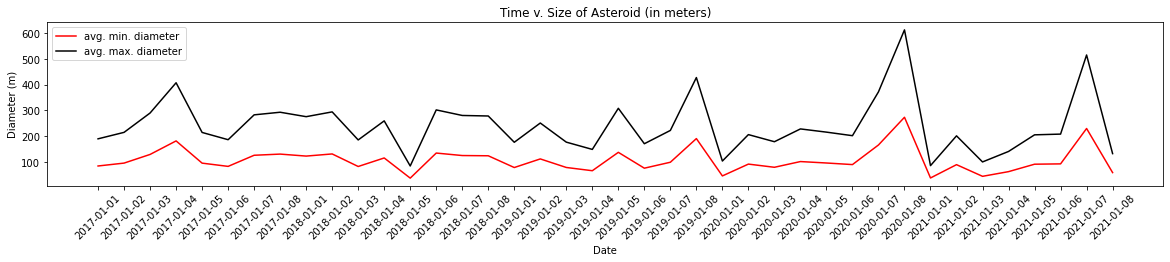

In [19]:
fig = plt.figure(figsize=(20, 3))
plt.plot(size_day_df.index, size_day_df.min_diam_m, color='red', label='avg. min. diameter')
plt.plot(size_day_df.index, size_day_df.max_diam_m, color='black', label='avg. max. diameter')

plt.title('Time v. Size of Asteroid (in meters)')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Diameter (m)')
plt.legend();

plt.savefig('Resources/assets/images/time_size_m_line.png', dpi=400)

In [20]:
full_data = pd.merge(proximity_df, asteroid_specs_df, on='id', how='left')
full_data.head()

,id,approach_date,velocity_kps,velocity_kph,velocity_mph,miss_dist_km,miss_dist_mi,day,asteroid_name,min_diam_m,max_diam_m,min_diam_f,max_diam_f,hazard_to_earth
0,3471590,2021-01-02,13.155437,47359.574574,29427.397879,3.781750e+07,2.349871e+07,2021-01-02,(2009 TK12),201.629919,450.858206,661.515505,1479.193637,True
1,3477945,2021-01-02,9.199820,33119.353743,20579.078441,3.564123e+07,2.214643e+07,2021-01-02,(2009 WN8),24.241248,54.205079,79.531656,177.838190,False
2,3703247,2021-01-02,22.553298,81191.873402,50449.472670,5.291687e+07,3.288102e+07,2021-01-02,(2014 YD42),96.506147,215.794305,316.621227,707.986587,False
3,3756788,2021-01-02,18.045971,64965.496106,40367.032844,5.639298e+07,3.504097e+07,2021-01-02,(2016 PN),221.082810,494.356193,725.337328,1621.903571,False
4,3766183,2021-01-02,18.378334,66162.001234,41110.494600,7.159084e+07,4.448448e+07,2021-01-02,(2016 YS8),139.493823,311.917671,457.656914,1023.351970,False


In [21]:
import seaborn as sns

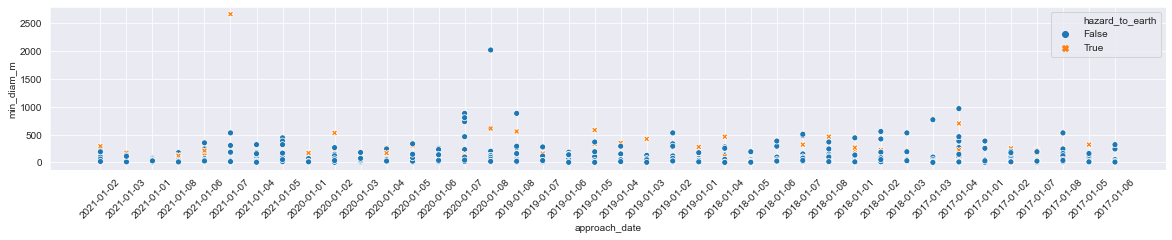

In [22]:
fig = plt.figure(figsize=(20, 3))
sns.set_style('darkgrid')
sns.scatterplot(x="approach_date", y="min_diam_m",
             hue="hazard_to_earth", style="hazard_to_earth",
             data=full_data)
plt.xticks(rotation=45)
plt.savefig('Resources/assets/images/time_size_m_scatter.png', dpi=400)
plt.grid(True);

In [23]:
# sns.set_style('darkgrid')
# sns.scatterplot(data=full_data, 
#                 x="max_diam_m", y="velocity_kph", 
#                 hue="hazard_to_earth", style="hazard_to_earth")
# plt.grid(True);

In [24]:
# sns.set_style('darkgrid')
# sns.scatterplot(data=full_data, 
#                 x="miss_dist_km", y="velocity_kph", 
#                 hue="hazard_to_earth", style="hazard_to_earth")
# plt.grid(True);

In [25]:
full_data.head()

,id,approach_date,velocity_kps,velocity_kph,velocity_mph,miss_dist_km,miss_dist_mi,day,asteroid_name,min_diam_m,max_diam_m,min_diam_f,max_diam_f,hazard_to_earth
0,3471590,2021-01-02,13.155437,47359.574574,29427.397879,3.781750e+07,2.349871e+07,2021-01-02,(2009 TK12),201.629919,450.858206,661.515505,1479.193637,True
1,3477945,2021-01-02,9.199820,33119.353743,20579.078441,3.564123e+07,2.214643e+07,2021-01-02,(2009 WN8),24.241248,54.205079,79.531656,177.838190,False
2,3703247,2021-01-02,22.553298,81191.873402,50449.472670,5.291687e+07,3.288102e+07,2021-01-02,(2014 YD42),96.506147,215.794305,316.621227,707.986587,False
3,3756788,2021-01-02,18.045971,64965.496106,40367.032844,5.639298e+07,3.504097e+07,2021-01-02,(2016 PN),221.082810,494.356193,725.337328,1621.903571,False
4,3766183,2021-01-02,18.378334,66162.001234,41110.494600,7.159084e+07,4.448448e+07,2021-01-02,(2016 YS8),139.493823,311.917671,457.656914,1023.351970,False


In [26]:
def makeScatter(year, x, y):
    year_data = full_data[full_data.loc[:, 'approach_date'] > f'{year}-12-31']
    sns.set_style('darkgrid')
    sns.scatterplot(data=year_data, 
                x=x, y=y, 
                hue="hazard_to_earth", style="hazard_to_earth")
    plt.title(f'Asteroids from first week in {str(int(year) + 1)}')
    plt.savefig(f'Resources/assets/images/{str(int(year) + 1)}_{x}_{y}_scatter.png', dpi=400)
    plt.grid(True);

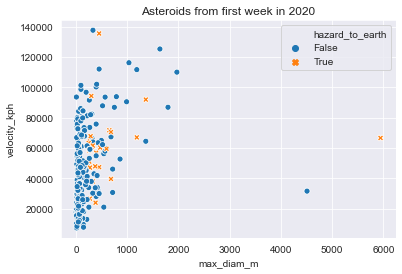

In [27]:
makeScatter('2019', "max_diam_m", "velocity_kph")

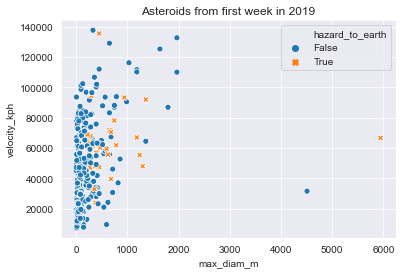

In [28]:
makeScatter('2018', "max_diam_m", "velocity_kph")

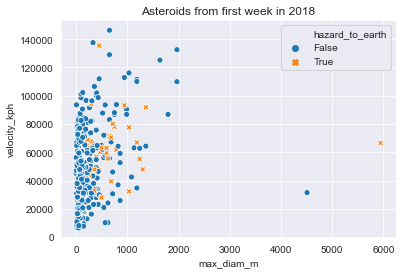

In [29]:
makeScatter('2017', "max_diam_m", "velocity_kph")

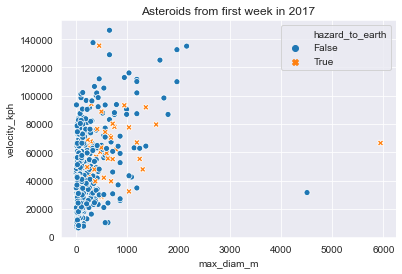

In [30]:
makeScatter('2016', "max_diam_m", "velocity_kph")

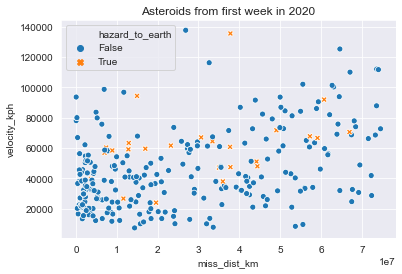

In [31]:
makeScatter('2019', "miss_dist_km", "velocity_kph")

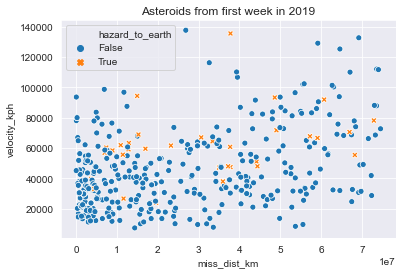

In [32]:
makeScatter('2018', "miss_dist_km", "velocity_kph")

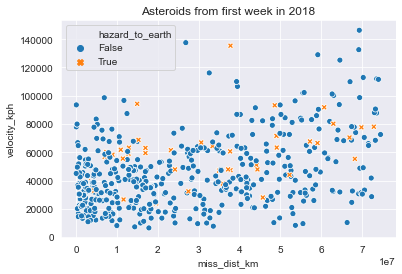

In [33]:
makeScatter('2017', "miss_dist_km", "velocity_kph")

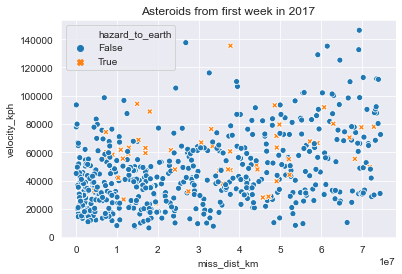

In [34]:
makeScatter('2016', "miss_dist_km", "velocity_kph")

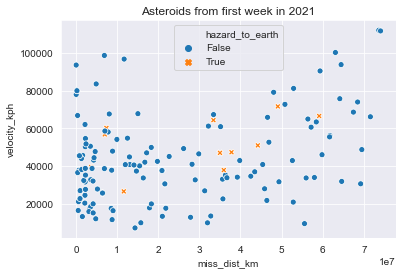

In [35]:
makeScatter('2020', "miss_dist_km", "velocity_kph")

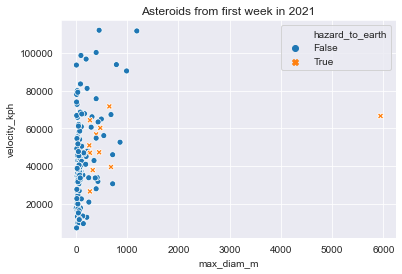

In [36]:
makeScatter('2020', "max_diam_m", "velocity_kph")